# Persistence
Here we are attempting to include temporary persistence in our workflow

## 1. Import dependencies

In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver                           # This is the tool that we will use to save the state temporarily in the memory as checkpoints
from langchain_ollama.chat_models import ChatOllama
from typing import TypedDict
from typing import Literal                                                      # This will be required to declare the return type of the conditional function

This is for graphing purpose

In [2]:
import nest_asyncio
nest_asyncio.apply()
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image

## 2. Linking the model

In [3]:
llm = ChatOllama(model="llama3.1:8b")

## 3. Create a state

In [4]:
class JokeState(TypedDict):                      # The JokeState inherits a TypedDict
    topic: str
    joke: str
    explanation: str

## 4. Define the function for the graph node

In [5]:
def generate_joke(state: JokeState):

    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content

    return {'joke': response}

In [6]:
def generate_explanation(state: JokeState):

    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = llm.invoke(prompt).content

    return {'explanation': response}

In [ ]:
def choice(state: JokeState) -> Literal[END, "generate_joke"]:
    print(f"The Joke is: {state['joke']}")
    print(f"The Explanation is: {state['explanation']}")
    consent = input("Do you wish to continue").strip().lower()
    if consent == "y":
        return "generate_joke"
    else:
        return END

## 5. Create the graph

In [ ]:
# Declare the graph:
graph = StateGraph(JokeState)                    # The StateGraph takes the state as a parameter, signifying that the "state" will be exchanged between the nodes through the edges.

# Add a nodes/states to the graph:
graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

# Add the sequential edges:
graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_conditional_edges('generate_explanation', choice)

### Incorporate the checkpointer

In [9]:
checkpointer = InMemorySaver()

## 6. Compile the graph while incorporating the checkpointer

In [10]:
workflow = graph.compile(checkpointer=checkpointer)

## 7. The Graph

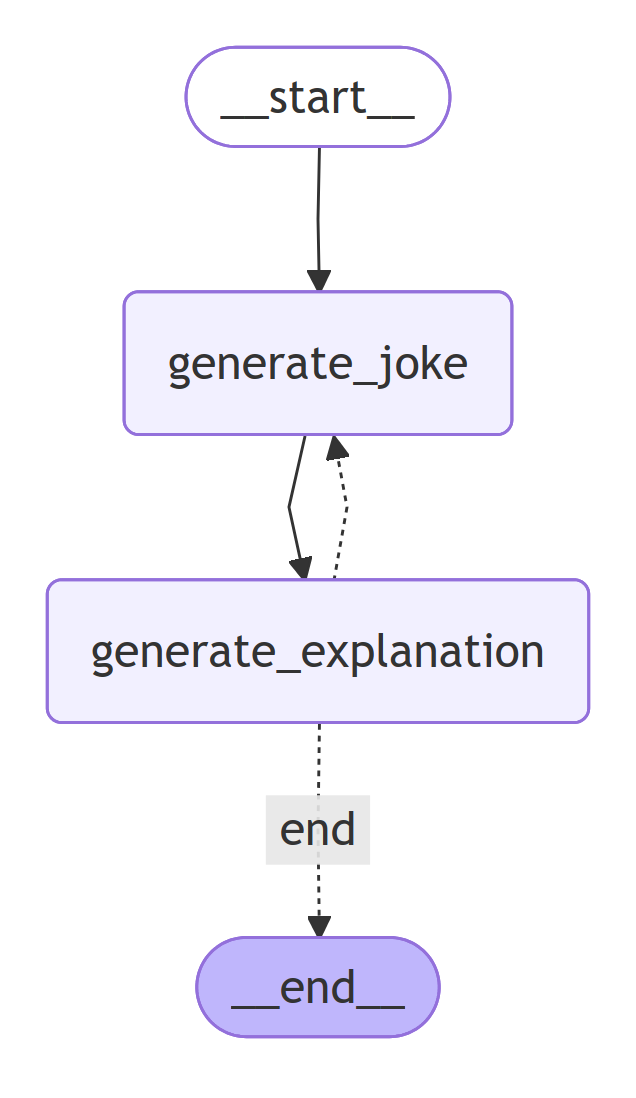

In [11]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

# 8. Incorporate the thread in config
To incorporate persistence, we are required to mention threads for each conversation, so that two different conversations do not pollute each other.

In [12]:
config1 = {"configurable": {"thread_id": "1"}}

In [13]:
config2 = {"configurable": {"thread_id": "2"}}

## 9. Run the code

In [14]:
# First Thread
final_state = workflow.invoke({'topic':'pizza'}, config=config1)
print(final_state)

The Joke is: Here's one:

Why was the pizza in a bad mood?

Because it was feeling crusty! (get it?)
The Explanation is: The joke is a play on words, using a pun to create humor. The word "crusty" has a double meaning here:

* In everyday language, "crusty" can refer to something that's old or stale, which might describe a piece of bread, like the crust of a pizza.
* However, "crusty" is also an adjective used to describe someone who's feeling grumpy or irritable.

The joke sets up the expectation that the question will be answered with a reason related to the pizza's physical properties (e.g., it's too hot, cold, or soggy). But instead, it subverts this expectation by using "crusty" in its second sense – implying that the pizza is feeling irritable. The punchline relies on this wordplay to create the humor.
{'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty! (get it?)", 'explanation': 'The joke is a play on words, using a pun t

In [15]:
# Second Thread
final_state = workflow.invoke({'topic':'pasta'}, config=config2)
print(final_state)

The Joke is: Here's one:

Why did the spaghetti go to therapy?

Because it was feeling a little "twisted"! (get it?)
The Explanation is: Here's the explanation for the joke:

The joke is a play on words, using a pun to create humor. The word "twisted" has a double meaning here: 

* In the context of spaghetti, "twisted" refers to the way spaghetti noodles are shaped - twisted or curled into different forms.
* However, in psychological therapy, being "twisted" can also imply that someone is feeling anxious, stressed, or mentally unwell.

The joke relies on this wordplay to create a clever connection between the setup (the spaghetti going to therapy) and the punchline ("feeling a little 'twisted'"). The humor comes from the unexpected twist (pun intended!) of applying a common phrase associated with mental health to a simple food item, creating a lighthearted and silly comparison.
The Joke is: Why did the spaghetti go to therapy? 

Because it was feeling drained.
The Explanation is: A ta

In [17]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty! (get it?)", 'explanation': 'The joke is a play on words, using a pun to create humor. The word "crusty" has a double meaning here:\n\n* In everyday language, "crusty" can refer to something that\'s old or stale, which might describe a piece of bread, like the crust of a pizza.\n* However, "crusty" is also an adjective used to describe someone who\'s feeling grumpy or irritable.\n\nThe joke sets up the expectation that the question will be answered with a reason related to the pizza\'s physical properties (e.g., it\'s too hot, cold, or soggy). But instead, it subverts this expectation by using "crusty" in its second sense – implying that the pizza is feeling irritable. The punchline relies on this wordplay to create the humor.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b314a-845d-6ec5-8002-d609b464f06a'}}

In [18]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'pasta', 'joke': "Here's one:\n\nWhy did the spaghetti refuse to get married?\n\nBecause it was afraid of being tied down! (get it?)", 'explanation': 'The joke is a play on words. The phrase "being tied down" has a double meaning here.\n\nIn one sense, marriage often involves making long-term commitments and responsibilities, which can be restrictive or limiting in some way. So, when the spaghetti says it\'s afraid of being "tied down", it\'s implying that it doesn\'t want to give up its freedom and autonomy by getting married.\n\nHowever, the word "tied" also has a literal meaning related to cooking. Spaghetti is a type of long, thin pasta that is typically cooked in boiling water until it\'s al dente (firm to the bite). To prevent the spaghetti from becoming mushy or tangled, cooks often use tongs or a fork to gently tie the strands together into a neat bundle, known as a "bundle" or "twist".\n\nSo, when the joke says that the spaghetti is afraid of bei

# 10. Checking the checkpoint status

In [19]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty! (get it?)", 'explanation': 'The joke is a play on words, using a pun to create humor. The word "crusty" has a double meaning here:\n\n* In everyday language, "crusty" can refer to something that\'s old or stale, which might describe a piece of bread, like the crust of a pizza.\n* However, "crusty" is also an adjective used to describe someone who\'s feeling grumpy or irritable.\n\nThe joke sets up the expectation that the question will be answered with a reason related to the pizza\'s physical properties (e.g., it\'s too hot, cold, or soggy). But instead, it subverts this expectation by using "crusty" in its second sense – implying that the pizza is feeling irritable. The punchline relies on this wordplay to create the humor.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b314a-845d-6ec5-8002-d609b464f06a'}

In [20]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'pasta', 'joke': "Here's one:\n\nWhy did the spaghetti refuse to get married?\n\nBecause it was afraid of being tied down! (get it?)", 'explanation': 'The joke is a play on words. The phrase "being tied down" has a double meaning here.\n\nIn one sense, marriage often involves making long-term commitments and responsibilities, which can be restrictive or limiting in some way. So, when the spaghetti says it\'s afraid of being "tied down", it\'s implying that it doesn\'t want to give up its freedom and autonomy by getting married.\n\nHowever, the word "tied" also has a literal meaning related to cooking. Spaghetti is a type of long, thin pasta that is typically cooked in boiling water until it\'s al dente (firm to the bite). To prevent the spaghetti from becoming mushy or tangled, cooks often use tongs or a fork to gently tie the strands together into a neat bundle, known as a "bundle" or "twist".\n\nSo, when the joke says that the spaghetti is afraid of be

# 11. Re running the example

In [21]:
# First Thread
final_state = workflow.invoke(None, config=config1)
print(final_state)

{'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty! (get it?)", 'explanation': 'The joke is a play on words, using a pun to create humor. The word "crusty" has a double meaning here:\n\n* In everyday language, "crusty" can refer to something that\'s old or stale, which might describe a piece of bread, like the crust of a pizza.\n* However, "crusty" is also an adjective used to describe someone who\'s feeling grumpy or irritable.\n\nThe joke sets up the expectation that the question will be answered with a reason related to the pizza\'s physical properties (e.g., it\'s too hot, cold, or soggy). But instead, it subverts this expectation by using "crusty" in its second sense – implying that the pizza is feeling irritable. The punchline relies on this wordplay to create the humor.'}


In [22]:
# Second Thread
final_state = workflow.invoke(None, config=config2)
print(final_state)

{'topic': 'pasta', 'joke': "Here's one:\n\nWhy did the spaghetti refuse to get married?\n\nBecause it was afraid of being tied down! (get it?)", 'explanation': 'The joke is a play on words. The phrase "being tied down" has a double meaning here.\n\nIn one sense, marriage often involves making long-term commitments and responsibilities, which can be restrictive or limiting in some way. So, when the spaghetti says it\'s afraid of being "tied down", it\'s implying that it doesn\'t want to give up its freedom and autonomy by getting married.\n\nHowever, the word "tied" also has a literal meaning related to cooking. Spaghetti is a type of long, thin pasta that is typically cooked in boiling water until it\'s al dente (firm to the bite). To prevent the spaghetti from becoming mushy or tangled, cooks often use tongs or a fork to gently tie the strands together into a neat bundle, known as a "bundle" or "twist".\n\nSo, when the joke says that the spaghetti is afraid of being "tied down", it\'s